In [1]:
# Cell 1: Install dependencies
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install pyyaml==6.0  # Updated version that works with Python 3.10+
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install datasets matplotlib

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-1.13.1%2Bcu117-cp311-cp311-linux_x86_64.whl (1801.8 MB)
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.14.1+cu117 (from versions: 0.1.6, 0.2.0, 0.15.0+cu117, 0.15.1, 0.15.1+cu117, 0.15.2, 0.15.2+cu117, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0)
ERROR: No matching distribution found for torchvision==0.14.1+cu117
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-bnuu3yby
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-bnuu3yby
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd91

In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu124
CUDA available: True


In [3]:
from datasets import load_dataset
dataset = load_dataset("visual_genome", "relationships_v1.2.0", split="train[:100]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

visual_genome.py:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

The repository for visual_genome contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/visual_genome.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
import torch
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:


model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

model_final_68b088.pkl: 421MB [00:03, 116MB/s]                           


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [8]:
from detectron2.data import MetadataCatalog, DatasetMapper
cfg.DATASETS.TRAIN = ("visual_genome",)
MetadataCatalog.get("visual_genome").set(thing_classes=[""])  # Placeholder
model.meta = MetadataCatalog.get("visual_genome")

In [9]:
VG_CLASSES = [
    'person', 'clothing', 'dog', 'cat', 'tree', 'car', 'building', 'book',
    'chair', 'table', 'computer', 'cup', 'food', 'plant', 'vehicle', 'sign',
    'door', 'window', 'shoe', 'grass', 'ground', 'road', 'water', 'flower',
    'fruit', 'animal', 'boat', 'plane', 'train', 'bicycle', 'bag', 'phone',
    'clock', 'light', 'bed', 'desk', 'shelf', 'cabinet', 'mirror', 'towel',
    'box', 'paper', 'dish', 'utensil', 'bottle', 'glass', 'vegetable',
    'electronic', 'instrument', 'tool'
]  # Top 50 classes for demo

VG_RELATIONS = [
    'holding', 'wearing', 'sitting on', 'standing on', 'next to',
    'looking at', 'under', 'attached to', 'riding', 'eating', 'drinking',
    'flying', 'playing', 'covering', 'carrying', 'with', 'on back of',
    'walking on', 'lying on', 'in front of', 'behind', 'parked on',
    'growing on', 'hanging from', 'over', 'brushing', 'watching',
    'using', 'touching', 'feeding', 'reading', 'cooking', 'holding hand of'
]  # Top 33 relations

In [13]:
import cv2
import matplotlib.pyplot as plt
def draw_relationships(image, outputs, threshold=0.7):
    fig = plt.figure(figsize=(15, 10))
    frame = image.copy()

    # Convert to RGB if needed
    if len(frame.shape) == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    elif frame.shape[2] == 4:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)

    # Extract instances
    instances = outputs["instances"]
    boxes = instances.pred_boxes.tensor.cpu().numpy()
    scores = instances.scores.cpu().numpy()
    labels = instances.pred_classes.cpu().numpy()

    # Draw objects
    for box, score, label in zip(boxes, scores, labels):
        if score < threshold:
            continue
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        class_name = VG_CLASSES[label] if label < len(VG_CLASSES) else f"Obj {label}"
        cv2.putText(frame, f"{class_name} {score:.2f}", (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

    # Simple relationship detection (nearest neighbor demo)
    valid_boxes = [box for box, score in zip(boxes, scores) if score >= threshold]
    for i in range(len(valid_boxes)):
        for j in range(i+1, len(valid_boxes)):
            box1 = valid_boxes[i]
            box2 = valid_boxes[j]

            # Calculate centers and convert to integers
            center1 = (int((box1[0]+box1[2])//2), int((box1[1]+box1[3])//2))
            center2 = (int((box2[0]+box2[2])//2), int((box2[1]+box2[3])//2))

            # Draw relationship line
            cv2.line(frame, center1, center2, (0,0,255), 1)

            # Draw relationship text
            mid_point = ((center1[0] + center2[0])//2, (center1[1] + center2[1])//2)
            cv2.putText(frame, "related", mid_point,
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)

    plt.imshow(frame)
    plt.axis('off')
    plt.show()


In [14]:
def process_image(image):
    # Convert to numpy array
    image = np.array(image.convert("RGB"))
    height, width = image.shape[:2]

    # Prepare inputs
    inputs = {
        "image": torch.as_tensor(image.astype("float32").transpose(2, 0, 1)),
        "height": height,
        "width": width
    }

    # Run model
    with torch.no_grad():
        outputs = model([inputs])[0]

    return outputs


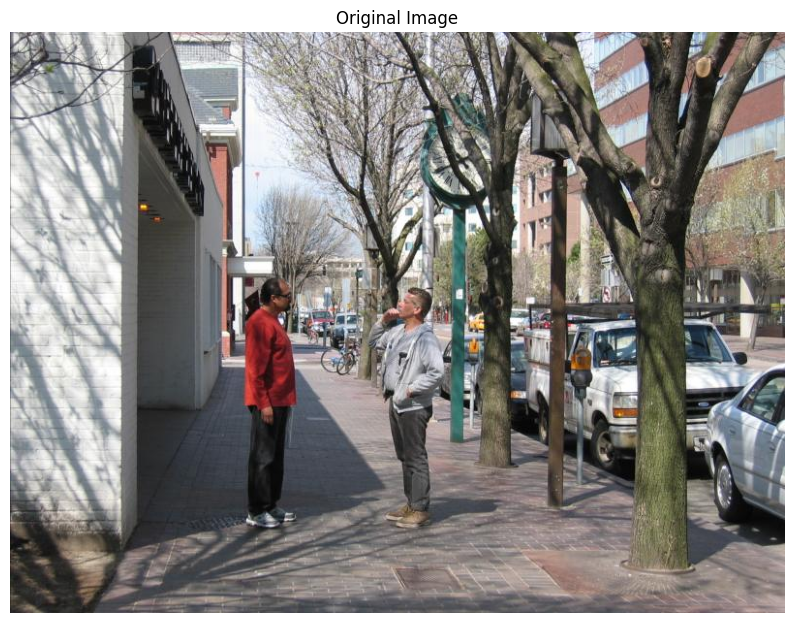

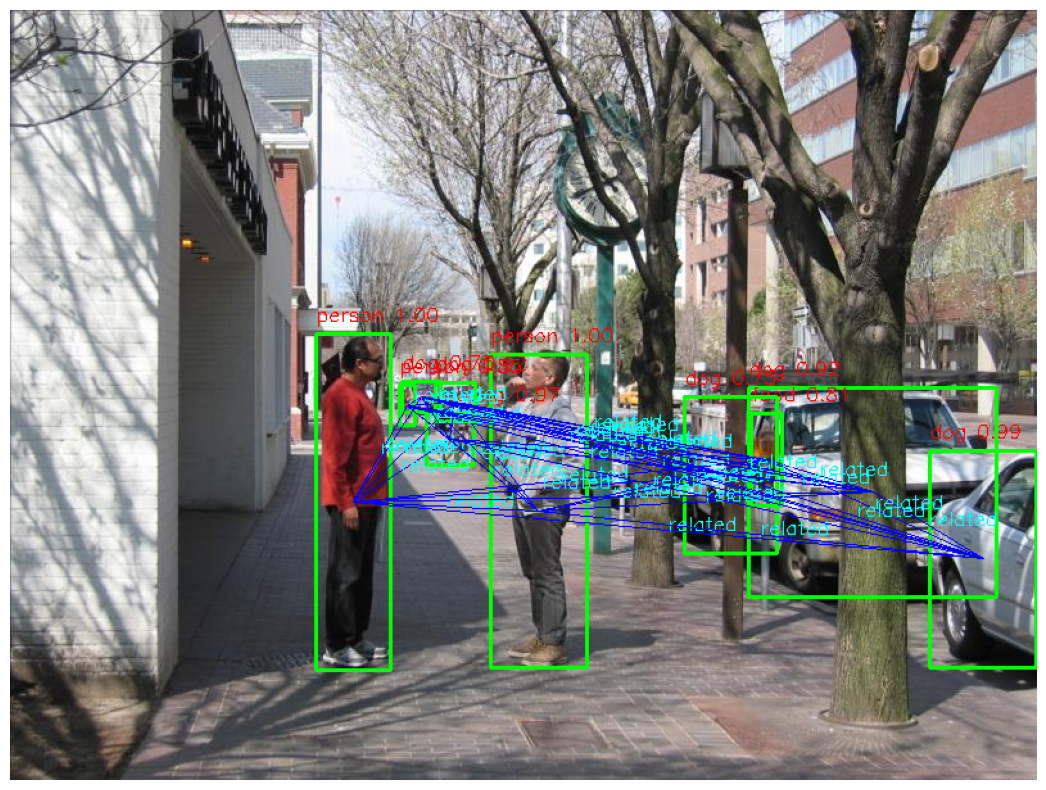

In [15]:
sample_idx = 0  # Try different indices (0-99)
sample = dataset[sample_idx]

# Original image
plt.figure(figsize=(10, 8))
plt.imshow(sample['image'])
plt.title("Original Image")
plt.axis('off')
plt.show()

# Process and visualize
outputs = process_image(sample['image'])
draw_relationships(np.array(sample['image']), outputs)

In [17]:
torch.save(model.state_dict(), "scene_graph_model.pth")
print("Model saved!")

Model saved!
